# DO NOT RUN! Removed API keys

# Load Dataset

In [ ]:
# Import modules
import pandas as pd
from google import genai
from google.genai import types
from PIL import Image, ImageFilter
from io import BytesIO
import base64
from IPython.display import display, Image as IPImage
import re
import csv
import random
import requests
from collections import Counter
import json

In [ ]:
# Load dataset
bme_zones = pd.read_csv("bme_zones_hackathon.csv")
# bme_zones.head()

In [ ]:
item_descriptions = pd.read_csv("item_descriptions_hackathon.csv")
# item_descriptions.head()

# Generate Questions using Gemini API

In [ ]:
client = genai.Client(api_key="")

In [ ]:
# Convert Pandas DataFrame to String
bme_zones_string = bme_zones.to_string()
item_descriptions_string = item_descriptions.to_string()

In [ ]:
# Choose Decades
decade_options = {
    "1": (1940, 1960),
    "2": (1960, 1980),
    "3": (1980, 2000),
    "4": (2000, 2020),
}

def get_user_decade_option():
  print("Choose a decade range:")
  print("1. 1940 - 1960")
  print("2. 1960 - 1980")
  print("3. 1980 - 2000")
  print("4. 2000 - 2020")

  while True:
    user_input = input("Enter the number of your choice (1 - 4): ")
    if user_input in decade_options:
      return decade_options[user_input]
    else:
      print("Invalid input. Please enter a number between 1 and 4.")

In [ ]:
# Filter data based on user input
start_year, end_year = get_user_decade_option()
filtered_data_bme = bme_zones[(bme_zones["start_year"] >= start_year) & (bme_zones["start_year"] <= end_year)]
filtered_data_bme_string = filtered_data_bme.to_string()
# print("Start year:", start_year)

Choose a decade range:
1. 1940 - 1960
2. 1960 - 1980
3. 1980 - 2000
4. 2000 - 2020
Enter the number of your choice (1 - 4): 2


In [ ]:
# Generate Multiple Choice Q&A
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[filtered_data_bme_string, "Generate 3 multiple choice questions and answers based on the dataset given. Your output should be question, 4 options, answers, and explanation."],
)

print(response.text)

quiz = response.text

Okay, here are 3 multiple-choice questions based on the provided text, along with answers and explanations:

**Question 1:**

Which musical style emerged as a reaction to the economic recession and unemployment in Britain during the mid to late 1970s?

(a) Glam
(b) New Romantic
(c) Punk
(d) Jazz Funk

**Answer:** (c) Punk

**Explanation:** The caption for zone 5 (1975-1985) explicitly states "Pop music reflected these conditions with tougher, more socially-engaged styles in reaction to the frivolity and camp of glam... Punk luridly dramatised Britain's social divisions..."

**Question 2:**

Which event is mentioned as a catalyst and subject for music during the psychedelic period?

(a) The British Invasion
(b) The emergence of Glam Rock
(c) Drug experimentation and themes of peace and sexual freedom
(d) Margaret Thatcher's premiership

**Answer:** (c) Drug experimentation and themes of peace and sexual freedom

**Explanation:** The caption for zone 3 (1966-1970) says that during the ps

In [ ]:
# Choose item from dataset
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[item_descriptions_string, "Choose an item in the dataset given. Your output should be object name and case"],
)

item = response.text.split("**")

object_name = item[2].strip()
case_number = item[4].strip()

print(object_name)
print(case_number)

# object_name = "The Beatles tour programme (turquoise)"
# case_naumber = "4.0"

The Beatles tour programme (turquoise)
4.0


In [ ]:
# Generate image based on the chosen item
response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=[object_name, "Find this item online, and generate the image"],
    config=types.GenerateContentConfig(response_modalities=["Text", "Image"]),
)

for part in response.candidates[0].content.parts:
    if part.text is not None:
        print(part.text)
    elif part.inline_data is not None:
        image_bytes = BytesIO(part.inline_data.data)

A search for "The Beatles tour programme turquoise" yields several results, predominantly on auction sites like eBay and specialized Beatles memorabilia shops.

Based on these results, the typical appearance of a **turquoise Beatles tour programme** (likely from their early to mid-1960s tours) would be something like this:

*   **Color:** The dominant color of the cover is a bright, often slightly glossy, turquoise blue.
*   **Text:** The band's name, "The Beatles," is usually prominently displayed on the cover in a contrasting color, often white, black, or sometimes a lighter shade of blue. The font is typically bold and easily readable.
*   **Imagery (Likely):** The cover often features a black and white photograph of the four members of The Beatles. This could be a posed group shot or a more candid stage photo.
*   **Layout:** The layout is generally clean and simple, focusing on the band's name and image. There might be additional text like "in Concert" or the tour year, but the tu

In [ ]:
# Extract all questions using regex
# Split the full text into individual question blocks
question_blocks = re.split(r"\*\*Question \d+:\*\*", quiz)[1:]

qa_pairs = []

for block in question_blocks:
    try:
        # Extract question
        question_match = re.search(r"(.*?)\n\(?a\)", block, re.DOTALL)
        question = question_match.group(1).strip()

        # Extract options
        options = re.findall(r"([a-d])\)\s(.+)", block)
        choices = {letter: text.strip() for letter, text in options[:4]}  # Only take first 4 choices

        # Extract answer
        answer_match = re.search(r"\*\*Answer:\*\*\s*\(?([a-d])\)?", block, re.IGNORECASE)
        answer = answer_match.group(1).strip().lower()

        # Extract explanation
        explanation_match = re.search(r"\*\*Explanation:\*\*\s*(.+?)(?=\n\*\*Question|\Z)", block, re.DOTALL)
        explanation = explanation_match.group(1).strip()

        qa_pairs.append({
            "question": question,
            "choices": choices,
            "answer": answer,
            "explanation": explanation
        })

    except Exception as e:
        print("Error parsing a question block:", e)
        print("Block:\n", block)
        print("-" * 40)

# Print a quick summary
# print(f"Parsed {len(qa_pairs)} questions successfully!")

In [ ]:
# Convert original image to base64 string
image_bytes.seek(0)
encoded_image = base64.b64encode(image_bytes.read()).decode("utf-8")

In [ ]:
# Save to CSV file
csv_filename = "quiz_questions.csv"

# Flatten and save
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write header
    writer.writerow(["question", "choice_a", "choice_b", "choice_c", "choice_d", "answer", "explanation", "original_image"])

    # Write data
    for qa in qa_pairs:
        writer.writerow([
            qa["question"],
            qa["choices"].get("a", ""),
            qa["choices"].get("b", ""),
            qa["choices"].get("c", ""),
            qa["choices"].get("d", ""),
            qa["answer"],
            qa["explanation"],
            ""
        ])

    image_question = "Based on the image provided, identify the object in the museum."
    writer.writerow([image_question, "", "", "", "", "", "", encoded_image])

# print(f"✅ Quiz saved to {csv_filename}")

In [ ]:
# Convert original image to base64 string
image_bytes.seek(0)
encoded_original_image = base64.b64encode(image_bytes.read()).decode("utf-8")

# Step 1 question
question_step1 = "🔍 Based on the image given, find the object in the museum and use your camera to scan the object."

# Create DataFrame
df = pd.DataFrame([{
    "question": question_step1,
    "original_image_base64": encoded_original_image
}])

# Save to CSV
df.to_csv("museum_question_image.csv", index=False)
# print("✅ Original image and question saved to CSV.")

# Q&A Example

In [ ]:
# Multiple choice
qa_df = pd.read_csv("quiz_questions.csv")

score = 0

for i, row in qa_df.iterrows():
    if pd.notna(row['original_image']):
        continue  # Skip this iteration and move to the next question

    # If it's a multiccple-choice question
    print(f"\n🔹 Question {i+1}: {row['question']}")
    choices = {
        'a': row.get('choice_a', '[Missing]'),
        'b': row.get('choice_b', '[Missing]'),
        'c': row.get('choice_c', '[Missing]'),
        'd': row.get('choice_d', '[Missing]')
    }

    for opt in ['a', 'b', 'c', 'd']:
        print(f"{opt}) {choices.get(opt)}")

    user_input = input("Your answer (a/b/c/d): ").strip().lower()
    if user_input == row['answer'].strip().lower():
        print("✅ Correct!")
        score += 1
    else:
        print(f"❌ Incorrect. Correct answer: {row['answer']}")
    print(f"💡 Explanation: {row['explanation']}")


🔹 Question 1: Which musical style emerged as a reaction to the economic recession and unemployment in Britain during the mid to late 1970s?
a) Glam
b) New Romantic
c) Punk
d) Jazz Funk
Your answer (a/b/c/d): c
✅ Correct!
💡 Explanation: The caption for zone 5 (1975-1985) explicitly states "Pop music reflected these conditions with tougher, more socially-engaged styles in reaction to the frivolity and camp of glam... Punk luridly dramatised Britain's social divisions..."

🔹 Question 2: Which event is mentioned as a catalyst and subject for music during the psychedelic period?
a) The British Invasion
b) The emergence of Glam Rock
c) Drug experimentation and themes of peace and sexual freedom
d) Margaret Thatcher's premiership
Your answer (a/b/c/d): c
✅ Correct!
💡 Explanation: The caption for zone 3 (1966-1970) says that during the psychedelic period, "Drug experimentation with themes of peace and sexual freedom became both the catalyst and subject for music, capturing the essence of this

🔍 Based on the image given, find the object in the museum and use your camera to scan the QR code 📷


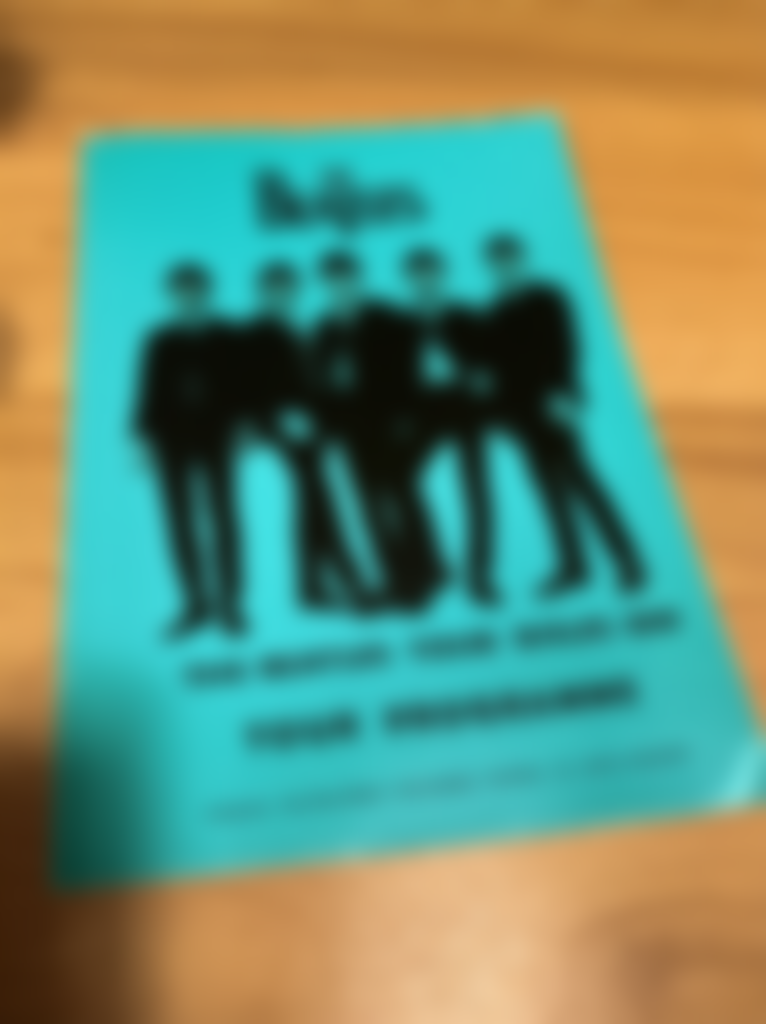

In [ ]:
# Image
for i, row in qa_df.iterrows():
    if pd.notna(row['original_image']):
        print("🔍 Based on the image given, find the object in the museum and use your camera to scan the QR code 📷")
        image_data = base64.b64decode(row['original_image'])

        image_bytes = BytesIO(image_data)
        original_image = Image.open(image_bytes)

        blurred_image = original_image.filter(ImageFilter.GaussianBlur(radius=10))  # Apply Gaussian blur
        blurred_image_bytes = BytesIO()
        blurred_image.save(blurred_image_bytes, format="PNG")  # Save blurred image as PNG

        # Display the blurred image
        display(IPImage(data=blurred_image_bytes.getvalue()))

        continue

In [ ]:
# Step 2: Ask if user wants first hint (case number)
need_hint = input("❓ Do you need a hint of the location? (yes/no): ").strip().lower()
case_number = int(float(case_number))
if need_hint == "yes":
    print(f"📦 Hint: The item is located in case {case_number}")
else:
    print("👍 Good luck!")

❓ Do you need a hint of the location? (yes/no): yes
📦 Hint: The item is located in case 4


🔍 Do you need a second hint (less blur image)? (yes/no): yes


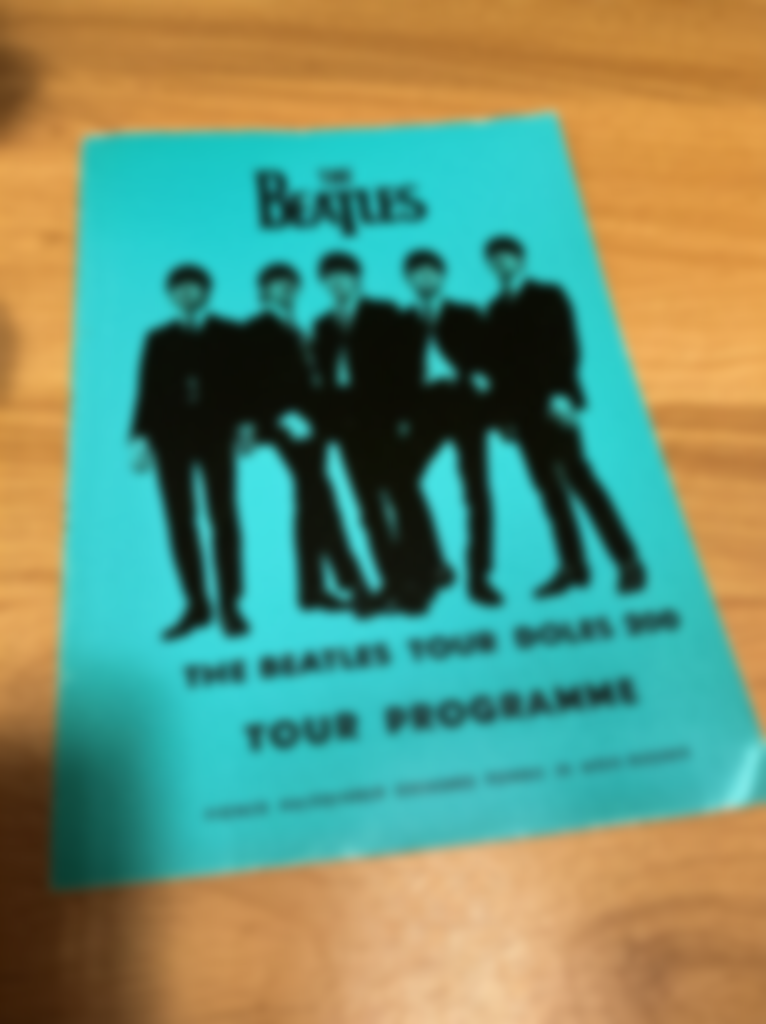

In [ ]:
# Step 3: Ask if user wants second hint (less blur)
need_second_hint = input("🔍 Do you need a second hint (less blur image)? (yes/no): ").strip().lower()
if need_second_hint == "yes":
    blurred_image_less = original_image.filter(ImageFilter.GaussianBlur(radius=5))
    blurred_image_less_bytes = BytesIO()
    blurred_image_less.save(blurred_image_less_bytes, format="PNG")
    display(IPImage(data=blurred_image_less_bytes.getvalue()))
else:
    print("👍 Good luck!")

In [ ]:
# Step 4: User input
give_up = input("😓 Do you want to give up? (yes/no): ").strip().lower()
if give_up == "yes":
    print(f"🔍 The correct answer was: {object_name}")
else:
    # Step 5: Final guess
    user_guess = input("🎯 What is your guess for the object name? (will be replaced with submit image): ").strip().lower()
    correct_answer = object_name.lower()

    if user_guess in correct_answer or correct_answer in user_guess:
        print("✅ Correct! You found the item.")
        score += 1
    else:
        print(f"❌ Incorrect. The correct answer was: {object_name}")

print(f"\n🎯 Final Score: {score} / {len(qa_df)}")

# The Beatles tour programme (turquoise)

😓 Do you want to give up? (yes/no): no
🎯 What is your guess for the object name? (will be replaced with submit image): The Beatles tour programme (turquoise)
✅ Correct! You found the item.

🎯 Final Score: 3 / 4


# Personalise by Difficulty level

In [ ]:
# Choose Age
difficulty_options = {
    "1": "easy",
    "2": "medium",
    "3": "hard",
}

def get_user_difficulty_option():
  print("Choose your difficulty level:")
  print("1. Easy")
  print("2. Medium")
  print("3. Hard")

  while True:
    user_input = input("Enter the number of your choice (1 - 3): ")
    if user_input in difficulty_options:
      return difficulty_options[user_input]
    else:
      print("Invalid input. Please enter a number between 1 and 3.")

difficulty_option = get_user_difficulty_option()

Choose your difficulty level:
1. Easy
2. Medium
3. Hard
Enter the number of your choice (1 - 3): 1


In [ ]:
def get_prompt_for_difficulty(difficulty_option):
    if difficulty_option == "easy":
        return "Generate 3 fun and super easy multiple-choice questions based on the dataset. Use clear language suitable for kids. Include relatable examples where helpful. Your output should be question, 4 options, answers, and explanation."
    elif difficulty_option == "medium":
        return "Generate 3 engaging and easy multiple-choice questions based on the dataset. Use clear language suitable for kids aged 7-12. Include relatable examples where helpful. Your output should be question, 4 options, answers, and explanation."
    else:
        return "Generate 3 interactive and informative multiple-choice questions and answers based on the dataset. Your output should be question, options, answers, and explanation."

# Use the function to build the prompt
custom_prompt = get_prompt_for_difficulty(difficulty_option)

# Generate Multiple Choice Q&A
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[bme_zones_string, custom_prompt],
)

print(response.text)

quiz = response.text

Okay, here are three fun and easy multiple-choice questions based on the dataset, designed for kids, along with the answers and explanations:

**Question 1:**

Which band was super popular and made "Girl Power" a thing in the mid-1990s?

a) The Beatles
b) Spice Girls
c) One Direction
d) Take That

**Answer:** b) Spice Girls

**Explanation:** Remember the Spice Girls? They were a super cool girl group who sang about friendship and being strong.  The caption for the years 1993-2004 says "Girl Power bursting onto the scene with the Spice Girls."

**Question 2:**

Before everyone had phones to listen to music, what kind of music did people like Lonnie Donegan play with instruments like washboards and tea chest bases in London clubs?

a) Heavy Metal
b) Big Band music
c) Skiffle
d) Glam Rock

**Answer:** c) Skiffle

**Explanation:** The caption for the years 1945-1962 says "...An equally popular genre of the 1950s was skiffle, a folk-blues revival launched by Lonnie Donegan. Its do-it-yourse

##Hitting the Spotify API and collecting the top Genres of the User.

In [321]:
combined_caption = ' '.join(bme_zones['caption'].dropna())

# Replace with your actual access token
access_token = ''
SPOTIFY_API_BASE_URL = 'https://api.spotify.com/v1'
TOP_ARTISTS_ENDPOINT = f'{SPOTIFY_API_BASE_URL}/me/top/artists?time_range=long_term&limit=50'  # Increase the limit for more data

def fetch_spotify_api(endpoint, method='GET', body=None):
    headers = {
        'Authorization': f'Bearer {access_token}',
        'Content-Type': 'application/json'
    }
    try:
        response = requests.request(method, endpoint, headers=headers, json=body)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching from Spotify API: {e}")
        return None

def get_top_artists():
    top_artists_data = fetch_spotify_api(TOP_ARTISTS_ENDPOINT)
    if top_artists_data and 'items' in top_artists_data:
        return top_artists_data['items']
    return []

def get_artist_genres(artist_id):
    artist_endpoint = f'{SPOTIFY_API_BASE_URL}/artists/{artist_id}'
    artist_data = fetch_spotify_api(artist_endpoint)
    if artist_data and 'genres' in artist_data:
        return artist_data['genres']
    return []

def get_top_genres(top_artists):
    all_genres = []
    for artist in top_artists:
        genres = get_artist_genres(artist['id'])
        all_genres.extend(genres)
    genre_counts = Counter(all_genres)
    return genre_counts.most_common()

if __name__ == "__main__":
    top_artists = get_top_artists()
    top_genres_list = []
    if top_artists:
        top_genres_with_counts = get_top_genres(top_artists)
        if top_genres_with_counts:
            print("Your Top Genres (Based on Top Artists - Long Term):")
            for genre, count in top_genres_with_counts:
                top_genres_list.append(genre)
                # print(f"- {genre} (Count: {count})")

        else:
            print("Could not determine top genres.")
    else:
        print("Could not retrieve top artists.")
    print(top_genres_list)

Your Top Genres (Based on Top Artists - Long Term):
['bedroom pop', 'indie', 'rap', 'bollywood', 'hindi pop', 'desi', 'r&b', 'garage rock', 'indian indie', 'pop', 'dream pop', 'k-pop', 'hip hop', 'alternative rock', 'psychedelic pop', 'experimental hip hop', 'alternative hip hop', 'experimental', 'desi hip hop', 'hindi hip hop', 'hyperpop', 'art pop', 'west coast hip hop', 'post-punk', 'sufi', 'shoegaze', 'jangle pop', 'gujarati garba', 'gujarati pop', 'indie pop', 'art rock', 'indie rock', 'rage rap', 'reggaeton', 'trap latino', 'latin', 'urbano latino', 'modern rock']


##Checking the common genres from the given data provided

In [322]:
combined_caption_lower = combined_caption.lower()
split_words = [word for phrase in top_genres_list for word in phrase.split()]

matches = [genre for genre in split_words if genre in combined_caption_lower]
unique_list_matches = []
for item in matches:
    if item not in unique_list_matches:
        unique_list_matches.append(item)

print(unique_list_matches)
# print("matches: ", matches)

['pop', 'desi', 'r&b', 'rock', 'hip', 'psychedelic', 'art']


##Specifying the Prompt for generating a quiz according to our personalised genre preference

In [338]:
prompt = f"""
Based on the BME Zones dataset, generate 3 multiple choice questions specifically focused
on the following genres that appear in the captions: {', '.join(unique_list_matches)}.

For each question:
1. Create a challenging and fun question related to these genres and in this format:*Question 2*
GENRE: Pop
The dataset suggests British pop music initially went global due to what?
A) The influence of the 'New Romantic' style
B) The introduction of music streaming services
C) The 'British Invasion' led by Beat groups
D) The rise of TV talent shows

Correct: C

2. Provide 4 options (A, B, C, D)
3. Indicate the correct answer, such as say, "Correct:"
4. When providing the questions, please do not make statements such as: "According to the data, or this dataset, ..."
5. When providing the questions, can you specify which genre is the question about? such as start the question as: "GENRE:"


Format each question with options and the answer on separate lines.
"""

In [339]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[bme_zones_string, prompt],
)
print(response.text)

*Question 1*
GENRE: Psychedelic
Which era saw psychedelic music intertwined with cultural exchange, political activity, and artistic expression?
A) The mid-1980s during a time of accelerated social change.
B) The mid-1960s during the 'Summer of Love'.
C) The early 1970s amidst economic crisis and the rise of glam rock.
D) The post-war period with the evolution of musical trends.

Correct: B

*Question 2*
GENRE: Rock
Before album-oriented rock became prominent, what format was dominant?
A) The 12" album
B) The music video
C) The 7" single
D) The Extended Play

Correct: C

*Question 3*
GENRE: Pop
Which of these pop trends emerged in response to economic challenges and social divisions?
A) The 'Cool Britannia' movement of the mid-1990s.
B) The glam rock movement of the early 1970s.
C) The punk movement of the mid-to-late 1970s.
D) The 'New Romantic' style of the early 1980s.

Correct: C



##Create a genre mapping based on the item_description.csv of the Items in the BME

In [329]:
def create_automated_genre_mapping(item_descriptions):
    # Define genre keywords to look for
    genres = {
        "jazz": ["jazz", "swing", "bebop", "dixieland"],
        "skiffle": ["skiffle"],
        "rock": ["rock", "guitar", "electric", "band"],
        "blues": ["blues", "rhythm and blues", "r&b"],
        "punk": ["punk", "sex pistols", "clash", "ramones"],
        "folk": ["folk", "acoustic", "traditional"],
        "psychedelic": ["psychedelic", "psych", "acid", "trippy"],
        "reggae": ["reggae", "ska", "dub", "caribbean"],
        "pop": ["pop", "chart", "boy band", "girl group"],
        "electronic": ["electronic", "synth", "techno", "dance"],
        "metal": ["metal", "heavy", "thrash", "hard rock"],
        "indie": ["indie", "alternative", "underground"],
        "britpop": ["britpop", "oasis", "blur", "pulp"]
    }

    # Initialize mapping dictionary
    genre_case_mapping = {genre: set() for genre in genres}

    # Analyze each item in the collection
    for index, row in item_descriptions.iterrows():
        object_name = str(row['Object name']).lower()
        case_number = row['Case']

        # Makes rows with no case number as 23
        if pd.isna(case_number):
            case_number = 23.0
        for genre, keywords in genres.items():
            for keyword in keywords:
                if keyword.lower() in object_name:
                    genre_case_mapping[genre].add(case_number)
                    break

    # Convert sets to lists for easier use
    return {genre: sorted(list(cases)) for genre, cases in genre_case_mapping.items()}

In [330]:
genre_case_mapping = create_automated_genre_mapping(item_descriptions)
print(genre_case_mapping)

{'jazz': [1.0, 2.0, 6.0], 'skiffle': [2.0], 'rock': [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19.0, 21.0, 22.0, 23.0], 'blues': [1.0, 6.0], 'punk': [13.0], 'folk': [2.0, 7.0, 22.0], 'psychedelic': [], 'reggae': [], 'pop': [20.0], 'electronic': [17.0], 'metal': [16.0, 19.0], 'indie': [8.0], 'britpop': [19.0]}


##Separate the questions, genres, options and answers.

In [340]:
pattern = r"GENRE: (.*?)\n(.*?)\nA\) (.*?)\nB\) (.*?)\nC\) (.*?)\nD\) (.*?)\n\nCorrect: ([A-D])"

matches = re.findall(pattern, response.text, re.DOTALL)

data = []
for genre, question, opt_a, opt_b, opt_c, opt_d, correct in matches:
    full_options = f"A) {opt_a.strip()}\nB) {opt_b.strip()}\nC) {opt_c.strip()}\nD) {opt_d.strip()}"

    data.append({
        'genre': genre.strip(),
        'question': question.strip(),
        'options': full_options,
        'answer': correct.strip()  # Just the letter
    })

df = pd.DataFrame(data)
print(df)
def get_casing(genre):
    genre_lower = genre.lower()
    if genre_lower in genre_case_mapping and genre_case_mapping[genre_lower]:
        return random.choice(genre_case_mapping[genre_lower])  # pick one randomly
    else:
        return 4.0  # or a default value like 0.0

# Apply the function to each row in your DataFrame
df['casing_number'] = df['genre'].apply(get_casing)

# View result
print(df)

         genre                                           question  \
0  Psychedelic  Which era saw psychedelic music intertwined wi...   
1         Rock  Before album-oriented rock became prominent, w...   
2          Pop  Which of these pop trends emerged in response ...   

                                             options answer  
0  A) The mid-1980s during a time of accelerated ...      B  
1  A) The 12" album\nB) The music video\nC) The 7...      C  
2  A) The 'Cool Britannia' movement of the mid-19...      C  
         genre                                           question  \
0  Psychedelic  Which era saw psychedelic music intertwined wi...   
1         Rock  Before album-oriented rock became prominent, w...   
2          Pop  Which of these pop trends emerged in response ...   

                                             options answer  casing_number  
0  A) The mid-1980s during a time of accelerated ...      B            4.0  
1  A) The 12" album\nB) The music video\nC) 

##Getting the Final Dataframe based on the questions asked and the case numbers


In [341]:
case_id_to_objects = item_descriptions.groupby('Case')['Object name'].apply(list).to_dict()

# Function to get a random object name based on casing_number
def get_random_object(case_id):
    objects = case_id_to_objects.get(case_id, [])
    if objects:
        return random.choice(objects)
    else:
        return None  # or a placeholder like 'No object found'

# Apply the function to your df
df['object_name'] = df['casing_number'].apply(get_random_object)

print(df)

         genre                                           question  \
0  Psychedelic  Which era saw psychedelic music intertwined wi...   
1         Rock  Before album-oriented rock became prominent, w...   
2          Pop  Which of these pop trends emerged in response ...   

                                             options answer  casing_number  \
0  A) The mid-1980s during a time of accelerated ...      B            4.0   
1  A) The 12" album\nB) The music video\nC) The 7...      C           17.0   
2  A) The 'Cool Britannia' movement of the mid-19...      C           20.0   

         object_name  
0         Help! book  
1              ‘Ask’  
2  Boyzone - 3no CDs  
